In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt


import datetime
from scipy.optimize import curve_fit
from scipy import stats
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from scipy.optimize import minimize_scalar


sns.set_context("paper", font_scale=1.6)

In [2]:
import sklearn
sklearn.__version__

'1.2.1'

# Loading data

Load the meta-analysis annotations into a Pandas DataFrame

In [3]:
# Load causal and explainability papers
causal = pd.read_excel('meta_analysis_data/Annotations_XAI_Biomedical.xlsx', sheet_name='Causal')
exp = pd.read_excel('meta_analysis_data/Annotations_XAI_Biomedical.xlsx', sheet_name='Explainability')

# Merge the two categories in a shared DataFrame
category = causal['paper category'].tolist() + exp['paper category'].tolist() 
dates = causal['date'].tolist() + exp['date'].tolist()
covid = causal['role of covid'].tolist() + exp['role of COVID'].tolist()
df = pd.DataFrame({'category': category, 'covid': covid, 'date': dates})# , "type":paper_type})
print('There are %d annotations in total' %df.shape[0])

# Remove duplicate entries, unrelated papers and works not in English
df = df.dropna()
df = df[(df['category'] != 'not in English') & (df['category'] != 'other error')]

# Format date as datetime object
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df = df.sort_values(by="date").reset_index(drop=True)
df

There are 1603 annotations in total


/home/gvisona/miniconda3/envs/series/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,category,covid,date
0,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-03-02
1,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-05-14
2,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-06-11
3,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-07-16
4,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2010-08-06
...,...,...,...
1270,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-01
1271,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-01
1272,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-01
1273,evaluation or application of XAI methods,Covid is not mentioned in the title or abstract,2022-11-02


In [4]:
# Build a DataFrame with monthly counts of Biomed XAI papers
df[['Year','Month', 'Day']] = df.date.dt.strftime('%Y-%m-%d').str.split("-",expand=True)
xai = df.groupby(['Month', 'Year']).size().reset_index()
xai.columns = ['Month', 'Year', 'Count']
xai['Year'] = xai['Year'].astype(int)
xai['Month'] = xai['Month'].astype(int)
xai["date"] = pd.to_datetime(dict(year=xai.Year, month=xai.Month, day=1))
xai = xai.sort_values(by = "date").reset_index(drop=True)


xai = xai.iloc[:-1] # Remove last entry for November 2022, which has incomplete data as of the analysis

# Add a month intervals to measure the number of months elapsed from the start of the measurements
delta_months = ((xai["date"] - xai["date"].iloc[0])/np.timedelta64(1,'M')).values
yy = xai["Count"].values
xai["DeltaMonth"] = delta_months

xai

,Month,Year,Count,date,DeltaMonth
0,3,2010,1,2010-03-01,0.000000
1,5,2010,1,2010-05-01,2.004148
2,6,2010,1,2010-06-01,3.022649
3,7,2010,1,2010-07-01,4.008296
4,8,2010,1,2010-08-01,5.026797
...,...,...,...,...,...
118,6,2022,51,2022-06-01,147.025606
119,7,2022,51,2022-07-01,148.011253
120,8,2022,34,2022-08-01,149.029754
121,9,2022,38,2022-09-01,150.048256


# Single exponential plot

Fit the trend data with a single exponential function

/tmp/ipykernel_211925/80969644.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  var_data = xai2.groupby("bin").var()["Count"]
/tmp/ipykernel_211925/80969644.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data = xai2.groupby("bin").mean()["Count"]


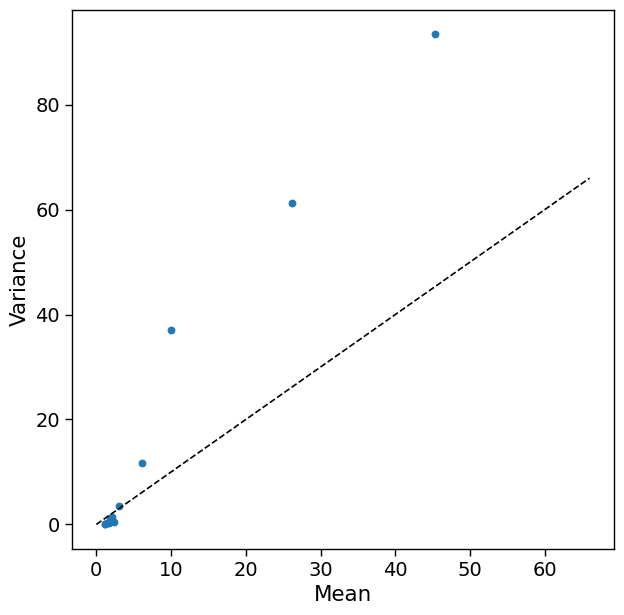

In [77]:
# Check overdispersion
xx = xai["DeltaMonth"].values
yy = xai["Count"].values

xai2 = xai.copy()
xai2["bin"] = pd.cut(xx, bins=12, labels=False)
xai2


fig, ax = plt.subplots(figsize=(7, 7))

var_data = xai2.groupby("bin").var()["Count"]
mean_data = xai2.groupby("bin").mean()["Count"]

ax.scatter(mean_data, var_data)

ax.set_ylabel("Variance")
ax.set_xlabel("Mean")

ax.plot([0, xai["Count"].max()], [0, xai["Count"].max()], color="black", linestyle="dashed")
plt.show()

In [6]:
# def exp_function(x, a, b):
#     return a * np.exp(b * x)

# fig, ax = plt.subplots(figsize=(15,5))

single_fit_XX = np.vstack([xx, np.zeros(len(xx))]).T

# popt, pcov = curve_fit(exp_function, xx, yy, p0=[1, 0.2])
# print("Optimal Parameters: ", popt)

# y_hat = exp_function(xx, *popt)

# residuals = yy-y_hat
# sse_single_fit = np.dot(residuals, residuals)

# r2_single_fit = r2_score(yy, y_hat)

# print("Single function SSE: {:.1f}".format(sse_single_fit))
# print("Single function R^2: {:.3f}".format(r2_single_fit))
# # print(sse_single_fit, r2_single_fit)

# ax.scatter(xai["date"], yy, s=50)
# ax.set_ylabel("# Biomed XAI papers [Monthly]")
# ax.set_xlabel("Date")
# ax.plot(xai["date"], y_hat, color="orange", linewidth=4)
# plt.show()

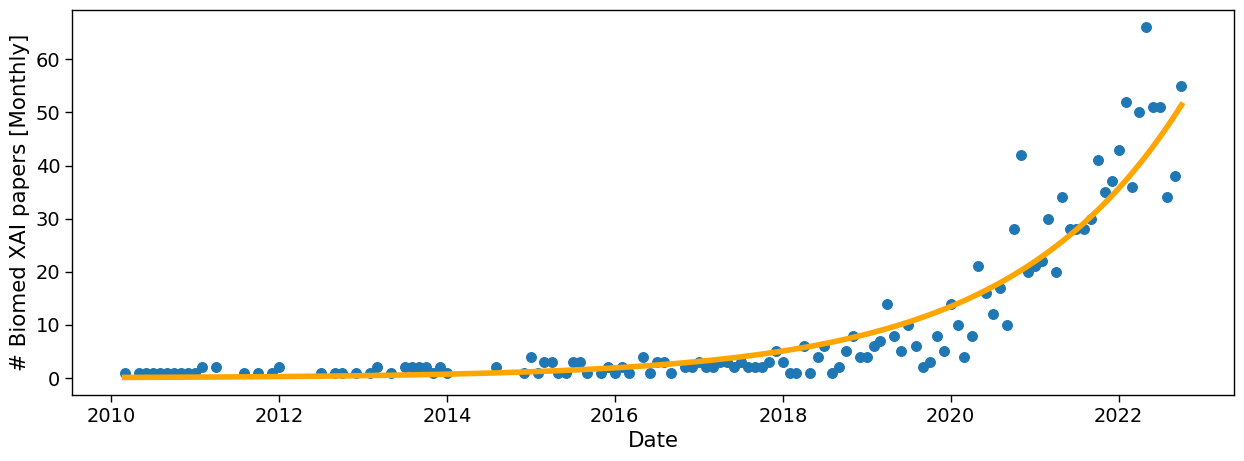

In [54]:
clf = linear_model.PoissonRegressor(fit_intercept=True, solver="newton-cholesky")

xx = xai["DeltaMonth"].values
yy = xai["Count"].values

clf.fit(xx.reshape(-1,1), yy)

single_fit_XX = np.vstack([xx, np.zeros(len(xx))]).T

y_hat = clf.predict(xx.reshape(-1,1))

residuals = yy-y_hat
sse_single_fit = np.dot(residuals, residuals)

r2_single_fit = r2_score(yy, y_hat)

fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(xai["date"], yy, s=50)
ax.set_ylabel("# Biomed XAI papers [Monthly]")
ax.set_xlabel("Date")
ax.plot(xai["date"], y_hat, color="orange", linewidth=4)

# ax.set_yscale("log")
plt.show()


# Piecewise exponential fit

Fit the trend data using a piecewise exponential function. We model the piecewise exponential using a single function
and including a threshold indicator (i.e. a Heaviside step function) to alter the parameters after a change in trend.

## Find the best splitting point

In [10]:
clf.coef_

array([0.0406082])

In [15]:
xx = xai["DeltaMonth"].values
yy = xai["Count"].values

squared_errors = []
popt_data = []



# We limit the possible split points to include sufficient data points in both sequences
# We start looking from the 10th data point to the 107th (i.e. 15-to-last) point.
sstart = 10
send = 15

for j in range(sstart, len(xai)-send):
    
    split_XX = np.vstack([xx, np.concatenate([np.zeros(j), np.ones(len(xx)- j)])]).T
    clf = linear_model.PoissonRegressor(fit_intercept=True, solver="newton-cholesky")
    
    clf.fit(split_XX, yy)
    y_hat_pw = clf.predict(split_XX)

    r2 = r2_score(yy, y_hat_pw) 

    residuals = yy - y_hat_pw
    sse = np.dot(residuals, residuals)
    squared_errors.append(sse)
    date = xai["date"].iloc[j]
    
    popt_data.append([j, sse, date, r2] + [clf.intercept_] + clf.coef_.tolist())

    
popt_data = pd.DataFrame(popt_data)
popt_data.columns = ["j", "SSE", "date", "R2"] + ["piecewise_popt_{}".format(c) for c in ["a", "b", "c"]]
popt_data

,j,SSE,date,R2,piecewise_popt_a,piecewise_popt_b,piecewise_popt_c
0,10,3052.288588,2011-02-01,0.886963,-2.127262,0.040629,-0.069130
1,11,3051.572440,2011-04-01,0.886990,-2.113695,0.040636,-0.083683
2,12,3050.725605,2011-08-01,0.887021,-2.100467,0.040645,-0.098069
3,13,3050.094600,2011-10-01,0.887045,-2.095329,0.040652,-0.104119
4,14,3049.395766,2011-12-01,0.887070,-2.090480,0.040659,-0.109983
...,...,...,...,...,...,...,...
93,103,2872.503552,2021-03-01,0.893621,-1.761236,0.036012,0.271895
94,104,2941.475904,2021-04-01,0.891067,-1.807070,0.036543,0.241618
95,105,2878.823430,2021-05-01,0.893387,-1.788257,0.036377,0.254348
96,106,2967.569626,2021-06-01,0.890101,-1.845718,0.037014,0.218190


<AxesSubplot: >

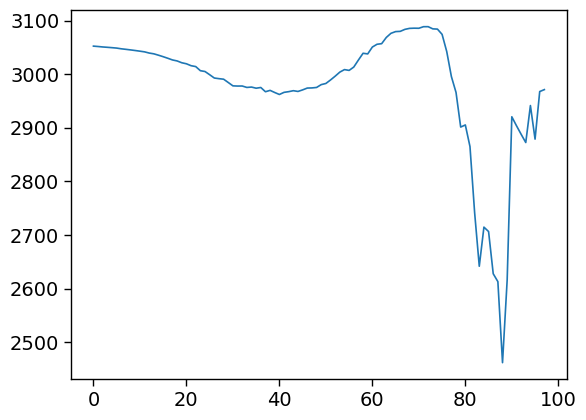

In [16]:
popt_data.SSE.plot()

In [18]:
# Show the best change point to start the second sequence

best_split = popt_data.iloc[np.argmin(popt_data["SSE"].values)]
j = best_split["j"]
# j = 80
# best_split = popt_data.iloc[80]
piecewise_popt = best_split.values[4:]
split_XX = np.vstack([xx, np.concatenate([np.zeros(j), np.ones(len(xx)- j)])]).T

clf = linear_model.PoissonRegressor(fit_intercept=True, solver="newton-cholesky")
clf.fit(split_XX, yy)
    
y_hat_split = clf.predict(split_XX)

print("Best splitting point at ", best_split.date)

Best splitting point at  2020-10-01 00:00:00


In [19]:
# Fix the trend change using the best split
xai["threshold"] = (xai["date"]>=best_split.date).astype(int)
xai

,Month,Year,Count,date,DeltaMonth,threshold
0,3,2010,1,2010-03-01,0.000000,0
1,5,2010,1,2010-05-01,2.004148,0
2,6,2010,1,2010-06-01,3.022649,0
3,7,2010,1,2010-07-01,4.008296,0
4,8,2010,1,2010-08-01,5.026797,0
...,...,...,...,...,...,...
118,6,2022,51,2022-06-01,147.025606,1
119,7,2022,51,2022-07-01,148.011253,1
120,8,2022,34,2022-08-01,149.029754,1
121,9,2022,38,2022-09-01,150.048256,1


## Evaluate average parameters using bootstrapping

In [20]:
# Calculate parameters for fit using bootstrapping
num_bootstrap = 1000

# Calculate the 95% confidence interval factor derived from a t-distribution
conf_int_factor = stats.t.isf(0.025, num_bootstrap-1)

bs_XX = xai[["DeltaMonth", "threshold"]].values

piecewise_params = []
counter = 0

np.random.seed(42)

pbar = tqdm(total=num_bootstrap)
while counter<num_bootstrap:
    df_tmp = xai.sample(frac=1, replace=True)
    yy_tmp = df_tmp["Count"]
    pw_fit_XX = df_tmp[["DeltaMonth", "threshold"]].values # np.vstack([df_tmp["DeltaMonth"], np.zeros(len(xx))]).T

    # Add a try-except block to avoid cases where we do not get numerical convergence
    try:
        clf = linear_model.PoissonRegressor(fit_intercept=True, solver="newton-cholesky")
        clf.fit(pw_fit_XX, yy)
    
        piecewise_params.append([clf.intercept_] + clf.coef_.tolist())
        counter += 1
        pbar.update(1)
    except:
        continue
        
piecewise_params = pd.DataFrame(piecewise_params)
piecewise_params.columns = ["a", "b", "c"]


params_means = piecewise_params.mean()
params_means_ci = conf_int_factor * piecewise_params.std()/np.sqrt(num_bootstrap)

print("Parameter means:\n", params_means, sep="")

  0%|          | 0/1000 [00:00<?, ?it/s]

Parameter means:
a    2.311049
b    0.000166
c   -0.011758
dtype: float64


## Calculate F-statistic to compare the single exponential fit vs the piecewise exponential

In [21]:
def calc_F_statistic(sse1, sse2, df1, df2):
    fstat = ((sse1-sse2)/(df1-df2)) / (sse2/df2)
    pval = stats.f.sf(fstat, df1, df2)
    return (fstat, pval)

# Number of degrees of freedom of the two models
dof1 = len(xai)-2
dof2 = len(xai)-3

fstat, pvalue = calc_F_statistic(sse_single_fit, best_split.SSE, dof1, dof2)

print(f"F-statistic: {fstat}  -  corresponding p-value: {pvalue}")

F-statistic: 28.86691285239208  -  corresponding p-value: 1.804920224484614e-55


## Plot the piecewise exponential fit

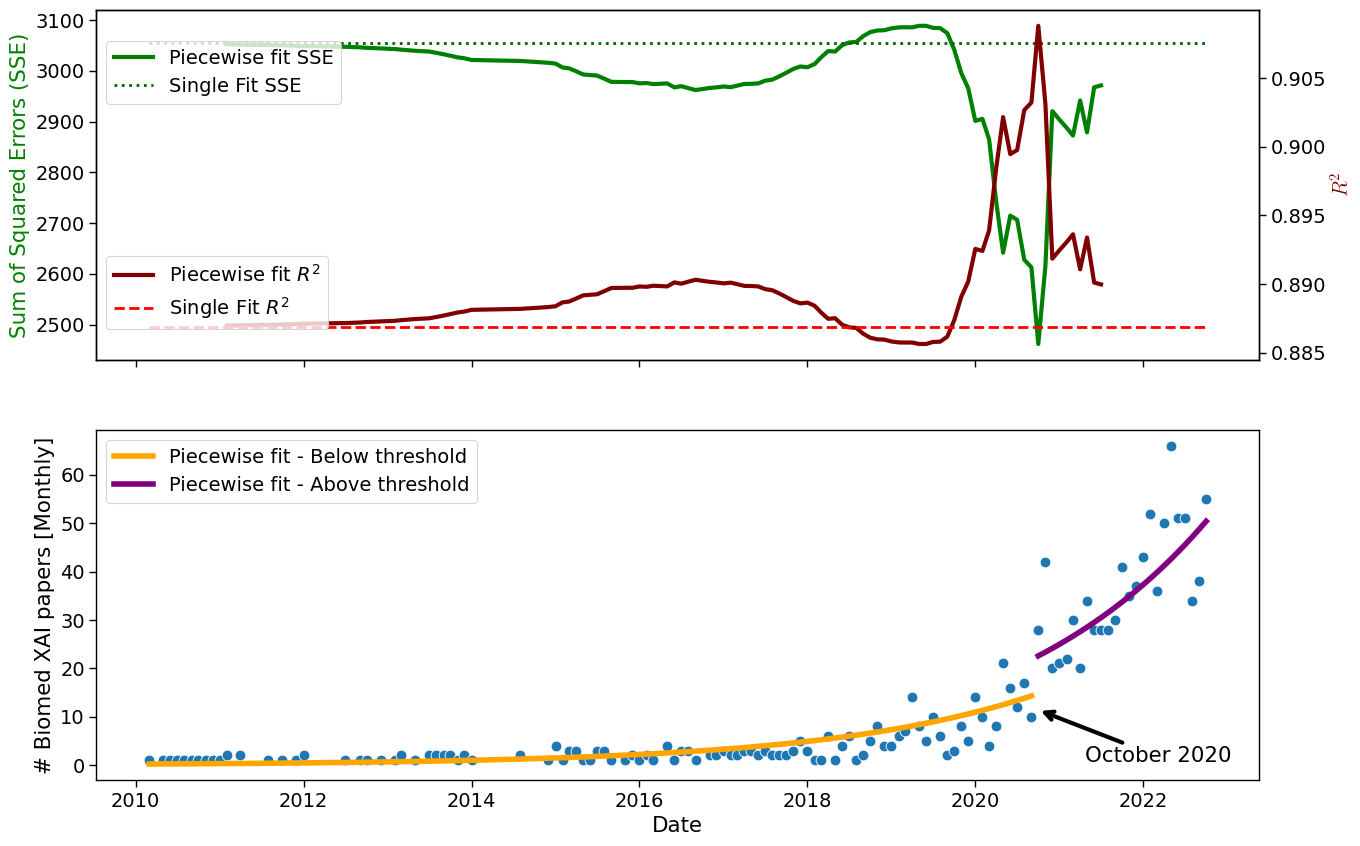

In [22]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15,10), sharex=True)

# Upper plot, SSE and R^2 for varying changepoints
ax.plot(xai['date'].iloc[sstart:-send], squared_errors, color="green", label="Piecewise fit SSE", linewidth=3)
ax.hlines(sse_single_fit, xai["date"].iloc[0], xai["date"].iloc[-1], linestyle="dotted", color="darkgreen", label="Single Fit SSE", linewidth=2)
ax.set_ylabel("Sum of Squared Errors (SSE)")
ax.legend(bbox_to_anchor=(0.0, 0.94), loc='upper left')

ax3 = ax.twinx()
ax3.set_ylabel(r"$R^2$", usetex=True)
ax3.plot(xai["date"].iloc[sstart:-send], popt_data["R2"], color="maroon", label=r"Piecewise fit $R^2$", linewidth=3)

ax3.hlines(r2_single_fit, xai["date"].iloc[0], xai["date"].iloc[-1], color="red", linestyle="dashed", label=r"Single Fit $R^2$", linewidth=2)
ax3.legend(bbox_to_anchor=(0.0, 0.06), loc='lower left')


ax.yaxis.label.set_color('green')
ax3.yaxis.label.set_color('maroon')


# ax2.text(0.01, 0.25, r"$y(x) = (a + b* \theta_D) * \mathscr{e}^{(c + d * \theta_D) * x}$" +"\n" +"\n" +
#          "$\overline{a} = %.3f \pm %.3f$" % (params_means.a, params_means_ci.a) +"\n"  +
#          "$\overline{b} = %.3f \pm %.3f$" % (params_means.b, params_means_ci.b) +"\n"  +
#          "$\overline{c} = %.3f \pm %.3f$" % (params_means.c, params_means_ci.c) +"\n"  +
#          "$\overline{d} = %.3f \pm %.3f$" % (params_means.d, params_means_ci.d), transform=ax2.transAxes)



# Bottom plot, best piecewise exponential fit and the corresponding observations
sns.scatterplot(data=xai, x="date", y="Count", ax=ax2, s=60)

# y_hat = piecewise_exp_function(single_fit_XX, *popt)
ax2.plot(xai["date"].iloc[:j], y_hat_split[:j], color="orange", linewidth=4, label="Piecewise fit - Below threshold")
ax2.plot(xai["date"].iloc[j:], y_hat_split[j:], color="purple", linewidth=4, label="Piecewise fit - Above threshold")
ax2.set_ylabel("# Biomed XAI papers [Monthly]")
ax2.set_xlabel("Date")
ax2.legend()


ax2.annotate("October 2020", xy=(0.81, 0.2), xytext=(0.85, 0.05), xycoords="axes fraction", textcoords="axes fraction", 
            arrowprops={"arrowstyle":"->", "color":"black", "lw": 3})


# ax2.set_yscale("log")
plt.show()
# fig.savefig("plots/xai_trend_changepoint_split.pdf", bbox_inches="tight")
plt.close(fig)

# Timeshift fit

Fit a single exponential function where the change in trend is modelled as a shift forward in time.

In [23]:
def timeskip_func(X, a, b, c):
    x = X[:,0]
    threshold = X[:,1]
    return (a) * np.exp(b * (x + c*threshold))

In [24]:
# Copy the previous dataframe and add a variable that is the difference in months centered on the optimal changepoint, october 2020
ts_df = xai.copy()
ts_df["CenteredDeltaMonth"] = ts_df["DeltaMonth"] - ts_df[ts_df["date"]==best_split.date]["DeltaMonth"].iloc[0]
ts_df = ts_df.assign(threshold=(ts_df["CenteredDeltaMonth"] >= 0).astype(int))
ts_df

,Month,Year,Count,date,DeltaMonth,threshold,CenteredDeltaMonth
0,3,2010,1,2010-03-01,0.000000,0,-127.049837
1,5,2010,1,2010-05-01,2.004148,0,-125.045689
2,6,2010,1,2010-06-01,3.022649,0,-124.027187
3,7,2010,1,2010-07-01,4.008296,0,-123.041541
4,8,2010,1,2010-08-01,5.026797,0,-122.023039
...,...,...,...,...,...,...,...
118,6,2022,51,2022-06-01,147.025606,1,19.975770
119,7,2022,51,2022-07-01,148.011253,1,20.961416
120,8,2022,34,2022-08-01,149.029754,1,21.979917
121,9,2022,38,2022-09-01,150.048256,1,22.998419


In [43]:
# Bootstrap to estimate the timeshift and its 95% confidence interval

np.random.seed(42)

delta_months = []
ts_R2 = []
ts_SSE = []
for num_iter in tqdm(range(num_bootstrap)):
    df2 = ts_df.sample(frac=1, replace=True)
    XX2 = df2[["CenteredDeltaMonth", "threshold"]].values
    
    yy2 = df2["Count"].values
    
    y_hat2 = None
    
    def timeskip_func(shift):
        global y_hat2
        x = XX2[:,0]
        threshold = XX2[:,1]
        x_adj = x + shift*threshold
        clf = linear_model.PoissonRegressor(fit_intercept=True, solver="newton-cholesky")
        clf.fit(x_adj.reshape(-1,1), yy2)
        
        y_hat2 = clf.predict(x_adj.reshape(-1,1))
        
        residuals = yy2-y_hat2
        return np.dot(residuals, residuals)

    shift = minimize_scalar(timeskip_func)
    residuals = yy2-y_hat2
    ts_R2.append(r2_score(yy2, y_hat2))
    ts_SSE.append(np.dot(residuals, residuals))

    if shift.success:
        delta_months.append(shift.x)
    
    
    
d_mean = np.mean(delta_months)
d_std_err = np.std(delta_months)/np.sqrt(num_bootstrap)


r2_mean = np.mean(ts_R2)
r2_ci = np.std(ts_R2)/np.sqrt(num_bootstrap-1) * conf_int_factor


sse_mean =  np.mean(ts_SSE)
sse_ci = np.std(ts_SSE)/np.sqrt(num_bootstrap-1) * conf_int_factor



  0%|          | 0/1000 [00:00<?, ?it/s]

In [44]:
d_mean

24.80719582384664

In [46]:
d_std_err

0.30527097341232917

In [47]:
# Add the adjusted date for plotting purposes (i.e. shift forward the datapoints after the change threshold
ts_df["AdjustedCenteredDeltaMonth"] = ts_df["CenteredDeltaMonth"] + d_mean*ts_df["threshold"]
ts_df["adjusted_date"] = ts_df["date"]+ dt.timedelta(days=d_mean*30)*ts_df["threshold"].astype(int)
ts_df

,Month,Year,Count,date,DeltaMonth,threshold,CenteredDeltaMonth,AdjustedCenteredDeltaMonth,adjusted_date
0,3,2010,1,2010-03-01,0.000000,0,-127.049837,-127.049837,2010-03-01 00:00:00.000000
1,5,2010,1,2010-05-01,2.004148,0,-125.045689,-125.045689,2010-05-01 00:00:00.000000
2,6,2010,1,2010-06-01,3.022649,0,-124.027187,-124.027187,2010-06-01 00:00:00.000000
3,7,2010,1,2010-07-01,4.008296,0,-123.041541,-123.041541,2010-07-01 00:00:00.000000
4,8,2010,1,2010-08-01,5.026797,0,-122.023039,-122.023039,2010-08-01 00:00:00.000000
...,...,...,...,...,...,...,...,...,...
118,6,2022,51,2022-06-01,147.025606,1,19.975770,44.782965,2024-06-14 05:10:51.575410
119,7,2022,51,2022-07-01,148.011253,1,20.961416,45.768612,2024-07-14 05:10:51.575410
120,8,2022,34,2022-08-01,149.029754,1,21.979917,46.787113,2024-08-14 05:10:51.575410
121,9,2022,38,2022-09-01,150.048256,1,22.998419,47.805615,2024-09-14 05:10:51.575410


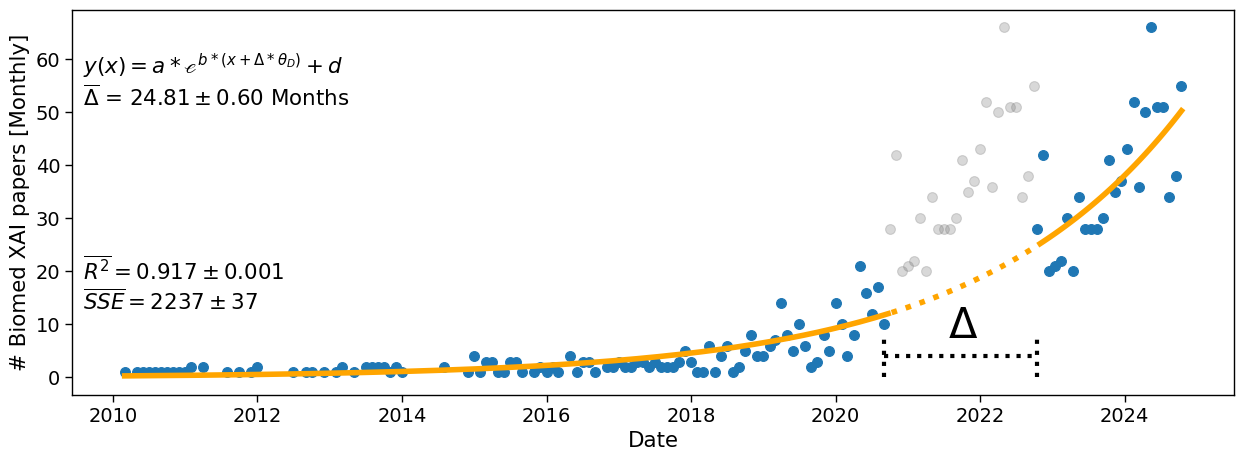

In [52]:
fig, ax = plt.subplots(figsize=(15,5))

# XX = ts_df[["CenteredDeltaMonth", "threshold"]].values
XX = ts_df[["AdjustedCenteredDeltaMonth"]].values
yy = ts_df["Count"].values

# popt_ts, pcov_ts = curve_fit(timeskip_exp_func, XX, yy, p0=[10.78841562,  0.03535449, 20.90241071])
clf = linear_model.PoissonRegressor(fit_intercept=True, solver="newton-cholesky")
clf.fit(XX, yy)

n_adj_points = ts_df["threshold"].sum()

adj_date = pd.date_range(start=ts_df["adjusted_date"].iloc[0],
                  end=ts_df["adjusted_date"].iloc[-1],
                  periods=300)



ax.scatter(ts_df[ts_df["threshold"]==1]["date"], yy[-n_adj_points:], color="gray", s=50, alpha=0.3)

ax.scatter(ts_df["adjusted_date"], yy, s=50)


XX_plot_1 = np.linspace(ts_df["AdjustedCenteredDeltaMonth"].iloc[0], ts_df["AdjustedCenteredDeltaMonth"].iloc[-1], 300).reshape(-1,1)

y_hat_plot1 = clf.predict(XX_plot_1)



adj_df = ts_df[ts_df["date"]!=ts_df["adjusted_date"]]

ix1 = np.where(adj_date<adj_df["date"].iloc[0])[0]
ax.plot(adj_date[ix1], y_hat_plot1[ix1], color="orange", linewidth=4)

ix2 = np.where((adj_date>=adj_df["date"].iloc[0])&(adj_date<adj_df["adjusted_date"].iloc[0]))[0]
ax.plot(adj_date[ix2], y_hat_plot1[ix2], color="orange", linewidth=4, linestyle="dotted")

ix3 = np.where(adj_date>=adj_df["adjusted_date"].iloc[0])[0]
ax.plot(adj_date[ix3], y_hat_plot1[ix3], color="orange", linewidth=4)



b1 = ts_df[ts_df["threshold"]==0]["adjusted_date"].iloc[-1]
b2 = ts_df[ts_df["threshold"]==1]["adjusted_date"].iloc[0]
ax.vlines(b1, 0, 8, color="black", linewidth=3, linestyle="dotted")
ax.vlines(b2, 0, 8, color="black", linewidth=3, linestyle="dotted")
ax.hlines(4, b1, b2, color="black", linewidth=3, linestyle="dotted")
ax.text(0.754, 0.147, r"$ \Delta$", transform=ax.transAxes, fontsize=30)


ax.text(0.01, 0.75, r"$y(x) = a * \mathscr{e}^{b * (x + \Delta* \theta_D)} + d$" + "\n" +
        r"$ \overline{\Delta}$" + r" = ${:.2f} \pm {:.2f}$ Months".format(d_mean, conf_int_factor*d_std_err), 
        transform=ax.transAxes)


ax.text(0.01, 0.3, r"$\overline{R^2}$" + "$ = {:.3f} \pm {:.3f}$".format(r2_mean, r2_ci), transform=ax.transAxes)
ax.text(0.01, 0.22, r"$\overline{SSE}$" + "$ = {:.0f} \pm {:.0f}$".format(sse_mean, sse_ci), transform=ax.transAxes)


ax.set_ylabel("# Biomed XAI papers [Monthly]")
ax.set_xlabel("Date")


# fig.savefig("plots/timeskip_changepoint.pdf", bbox_inches="tight")

# ax.set_yscale("log")
plt.show()